In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers

In [4]:
# Dataset paths
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'
TEST_DIR = '../dataset/test'

In [57]:
# Image Parameters
BATCH_SIZE = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Dataset Preprocessing

In [6]:
dataRescale = ImageDataGenerator(rescale=1./255)
dataAugment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Load and apply preprocessing

In [7]:
train_dataset_gen = dataRescale.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_dataset_gen = dataRescale.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_dataset_gen = dataRescale.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

# Augment train dataset
train_augmented = dataAugment.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 800 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 163 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


### Convert ImageDataGenerator to tf.data.Dataset

In [8]:
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32),  # (images, labels)
        output_shapes=(
            (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3),  # Shape of images
            (BATCH_SIZE, len(generator.class_indices))  # Shape of labels
        )
    )

In [9]:
train_dataset_augmented = generator_to_tf_dataset(train_augmented)
train_dataset = generator_to_tf_dataset(train_dataset_gen)
val_dataset = generator_to_tf_dataset(val_dataset_gen)
test_dataset = generator_to_tf_dataset(test_dataset_gen)

In [10]:
# Combine original and augmented train images
train_dataset = train_dataset.concatenate(train_dataset_augmented)

# Prefetch
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

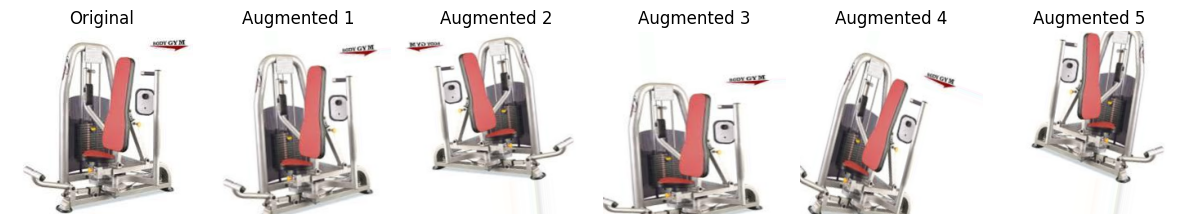

In [11]:
# Augmented sample
image = load_img('../dataset/train/Chest Fly Machine/google_0056_jpg.rf.cb67f38b9d146a379485175251fd3bda.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
image_array = img_to_array(image)
plt.figure(figsize=(12, 6))

# Show the original image
plt.subplot(1, 6, 1)
plt.imshow(image_array.astype('uint8'))
plt.title("Original")
plt.axis('off')

# Prepare the image for augmentation
image_array = np.expand_dims(image_array, axis=0)

# Generate augmented images
augmented_images = dataAugment.flow(image_array, batch_size=1)

# Plot augmented images
for i in range(5):
    augmented_image_array = next(augmented_images)[0]
    augmented_image_array = np.clip(augmented_image_array, 0, 1)  # Ensure values stay in range
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image_array)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Modeling

In [12]:
# load Pre-Trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.summary(show_trainable=True, expand_nested=True)

Model: "mobilenetv2_1.00_224"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']          

## Fine Tuning

In [13]:
# Freeze Selected Layer
freeze_to_layer = len(base_model.layers)
for layer in base_model.layers[:freeze_to_layer]:
      layer.trainable = False

In [58]:
def custom_model():
    
    input_layer = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(0.02))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    output_layer = tf.keras.layers.Dense(8, activation=tf.nn.softmax, kernel_regularizer=regularizers.L2(0.02))(x)
    
    # declare inputs and outputs
    cust_model = Model(inputs=input_layer, outputs=output_layer)
    
    return cust_model

In [59]:
model_ft = custom_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ft.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_ft.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
80/80 [==============================] - 8s 80ms/step - loss: 23.9106 - accuracy: 0.1544 - val_loss: 22.1663 - val_accuracy: 0.3562
Epoch 2/100
80/80 [==============================] - 10s 121ms/step - loss: 21.8546 - accuracy: 0.2062 - val_loss: 20.8231 - val_accuracy: 0.5063
Epoch 3/100
80/80 [==============================] - 11s 140ms/step - loss: 20.4356 - accuracy: 0.2525 - val_loss: 19.5550 - val_accuracy: 0.5188
Epoch 4/100
80/80 [==============================] - 11s 133ms/step - loss: 19.1230 - accuracy: 0.3081 - val_loss: 18.3196 - val_accuracy: 0.5250
Epoch 5/100
80/80 [==============================] - 11s 136ms/step - loss: 17.8664 - accuracy: 0.3669 - val_loss: 17.1301 - val_accuracy: 0.5250
Epoch 6/100
80/80 [==============================] - 10s 131ms/step - loss: 16.6557 - accuracy: 0.4269 - val_loss: 15.9948 - val_accuracy: 0.5188
Epoch 7/100
80/80 [==============================] - 11s 133ms/step - loss: 15.5604 - accuracy: 0.4669 - val_loss: 14.9510 - v

In [16]:
model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896 

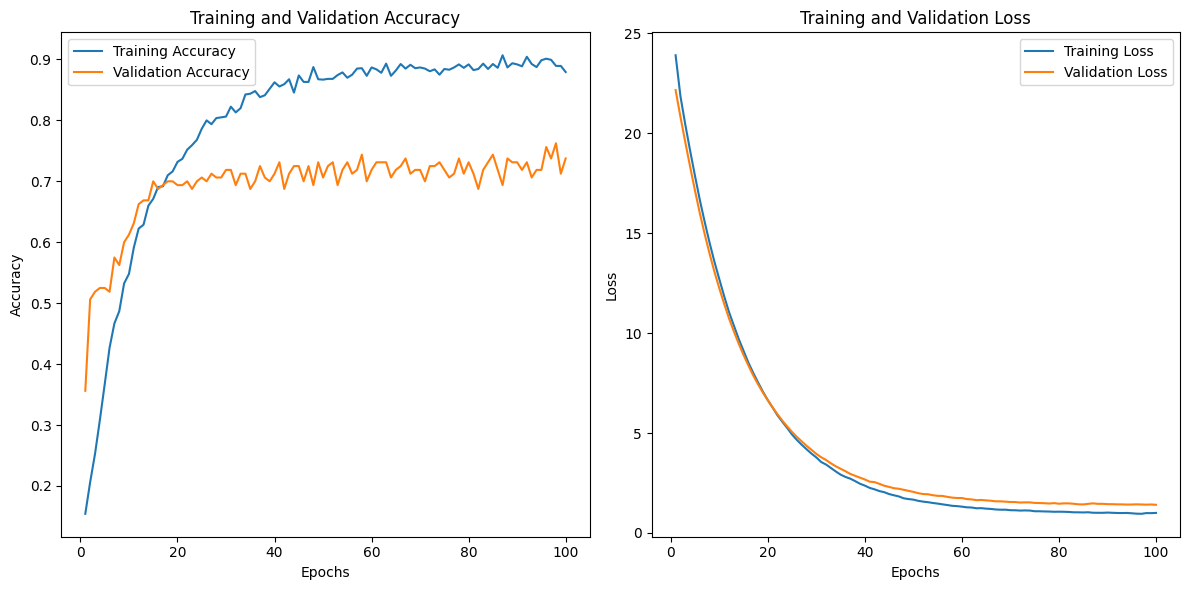

In [61]:
# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Defining the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()